In [1]:
import numpy as np
from scipy import misc
import cv2
import matplotlib.pyplot as plt
import time
import json
%matplotlib inline

import tensorflow as tf
from keras.models import Model
from keras.models import load_model
from keras.layers import Dense, Activation, Input
from keras.layers.normalization import BatchNormalization
from keras.callbacks import LearningRateScheduler, History
from keras.optimizers import Adam
from keras import backend as Keras

from sklearn import metrics
from scipy.spatial import distance

Using TensorFlow backend.


In [2]:
import os
import sys
sys.path.append('/home/albert/github/DenseNet/')
import densenet
sys.path.append('/home/albert/github/tensorflow/')
import triplet

### Mine Triplets

In [3]:
CAFFE_ROOT = '/home/albert/caffe/'
train_img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_train')
test_img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_test')

In [4]:
train_dict = {}
train_files = []
train_labels = []

for f in train_img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if not any(idt == l for l in train_labels):
            train_labels.append(idt)
            train_dict[idt] = []
        path = CAFFE_ROOT + 'data/market-1501/bounding_box_train/' + f
        train_files.append([path, idt])
        train_dict[idt].append(path)

train_labels.sort()

In [5]:
test_dict = {}
test_files = []
test_labels = []

for f in test_img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if idt != 0 and idt != -1:
            if not any(idt == l for l in test_labels):
                test_labels.append(idt)
                test_dict[idt] = []
            path = CAFFE_ROOT + 'data/market-1501/bounding_box_test/' + f
            test_files.append([path, idt])
            test_dict[idt].append(path)
        
test_labels.sort()

### Train Network

In [6]:
train_score = {}
test_score = {}

steps_per_epoch = 100

input_shape = (256,128)

overlay = True
overlay_eval = False
preprocess = False

# file_root = 'densenet_triplet_margin_preprocess_128x64'

False
True
0.748291969299


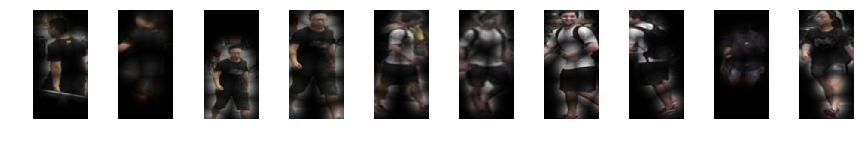

In [7]:
start = time.time()
batch = triplet.output_batch_generator(train_dict, train_labels,overlay=overlay, preprocess=False, 
                                                        shape=input_shape).next()
print time.time() - start

plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(batch[0][i].astype(np.uint8))
    plt.axis('off')
plt.show()

In [8]:
# First integer: number of epochs (e.g., 10)
# Second integer: era

epochs = 10

step_decay_cont_str = """
def step_decay_cont(epoch, init_epoch=%d*(%d - 1), init_lr=0.0003):
    drop = 0.5
    epochs_drop = 10.0
    t1 = 50.0
    if epoch + init_epoch < t1:
        lrate = init_lr
    else:
        lrate = init_lr * np.power(drop,  
               np.floor((epoch + init_epoch - t1 + epochs_drop)/(epochs_drop)))
    return lrate
"""

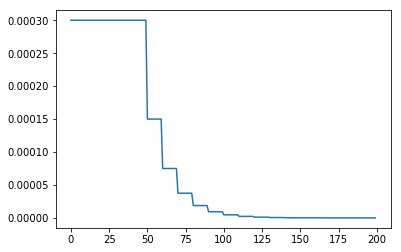

In [9]:
lr = []
for era in range(1,21):
    exec(step_decay_cont_str % (epochs, era))
    for j in range(10):
        lr.append(step_decay_cont(j))
plt.plot(np.arange(200), lr)

In [10]:
def plot_score(score):
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    pos_distance = score['pos_distance']
    neg_distance = score['neg_distance']
    bins = np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 100)
    plt.hist(pos_distance, bins, alpha=0.5, label='positive pair')
    plt.hist(neg_distance, bins, alpha=0.5, label='negative pair')
    plt.legend(loc='upper right')

    plt.subplot(1,3,2)
    plt.plot(score['recall'], score['precision'])
    plt.xlabel('recall')
    plt.ylabel('precision')

    plt.subplot(1,3,3)
    plt.plot(np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 101)[1:], 
             score['matt_coef'])
    plt.xlabel('dist')
    plt.ylabel('matt_coef')
    
    plt.show()

    print score['rank']

In [ ]:
base_model = densenet.DenseNetImageNet121(input_shape=(input_shape[0],input_shape[1],3))

base_model.outputs = [base_model.layers[-2].output]
base_model.layers[-1].outbound_nodes = []

x = base_model.outputs[0]
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
predictions = Dense(128)(x)

trinet = Model(inputs=base_model.input, outputs=predictions)
trinet.compile(loss=triplet.triplet_loss, 
               optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

for layer in trinet.layers:
    layer.trainable = True

Weights for the model were loaded successfully


In [ ]:
history = History()

for era in range(1,16):
    iterations = era * steps_per_epoch * epochs
    exec(step_decay_cont_str % (epochs, era))
    lrate = LearningRateScheduler(step_decay_cont)
    
    trinet.fit_generator(triplet.output_batch_generator(train_dict, train_labels, 
                                                        overlay=overlay, preprocess=preprocess, 
                                                        shape=input_shape), 
                         steps_per_epoch=steps_per_epoch,
                         epochs=epochs,
                         callbacks=[lrate, history])
    
    file_name = file_root + '_' + str(iterations) + '.h5'
    trinet.save('/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name))
    
    train_score[iterations] = triplet.get_score(trinet, train_dict, train_files, hist=history, 
                                        overlay=overlay_eval, train=True, preprocess=preprocess, 
                                               shape=input_shape)
    print 'train' , iterations
    plot_score(train_score[iterations])

    test_score[iterations] = triplet.get_score(trinet, test_dict, test_files, hist=history, 
                                        overlay=overlay_eval, train=False, preprocess=preprocess, 
                                               shape=input_shape)
    print 'test', iterations
    plot_score(test_score[iterations])

False
True
Epoch 1/10
100/100 [==============================] - 69s - loss: 310.5859    
Epoch 2/10
100/100 [==============================] - 70s - loss: 255.7889    
Epoch 3/10
100/100 [==============================] - 69s - loss: 240.0456    
Epoch 4/10
100/100 [==============================] - 69s - loss: 206.2252    
Epoch 5/10
100/100 [==============================] - 69s - loss: 198.6865    
Epoch 6/10
100/100 [==============================] - 69s - loss: 187.0063    
Epoch 7/10
 23/100 [=====>........................] - ETA: 52s - loss: 170.8749

In [ ]:
np.savez('/home/albert/github/tensorflow/models/%s/%s_score.npz' % (file_root, file_root), train_score)
np.savez('/home/albert/github/tensorflow/models/%s/%s_test_score.npz' % (file_root, file_root), test_score)

### Evaluation

In [ ]:
train_rank1_avg = []
train_rank5_avg = []
train_rank20_avg = []
test_rank1_avg = []
test_rank5_avg = []
test_rank20_avg = []

iterations = 15000

for it in range(1000,iterations + 1000,1000):
    train_rank1_avg.append(np.average(np.array(train_score[it]['rank'][1])))
    train_rank5_avg.append(np.average(np.array(train_score[it]['rank'][5])))
    train_rank20_avg.append(np.average(np.array(train_score[it]['rank'][20])))
    test_rank1_avg.append(np.average(np.array(test_score[it]['rank'][1])))
    test_rank5_avg.append(np.average(np.array(test_score[it]['rank'][5])))
    test_rank20_avg.append(np.average(np.array(test_score[it]['rank'][20])))

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(np.arange(1000,iterations+1000,1000), train_rank1_avg, label='train_rank1_avg', )
plt.plot(np.arange(1000,iterations+1000,1000), train_rank5_avg, label='train_rank5_avg', )
plt.plot(np.arange(1000,iterations+1000,1000), train_rank20_avg, label='train_rank20_avg')

plt.plot(np.arange(1000,iterations+1000,1000), test_rank1_avg, label='test_rank1_avg', linestyle='--')
plt.plot(np.arange(1000,iterations+1000,1000), test_rank5_avg, label='test_rank5_avg', linestyle='--')
plt.plot(np.arange(1000,iterations+1000,1000), test_rank20_avg, label='test_rank20_avg', linestyle='--')
plt.legend(loc='lower left')
plt.xlabel('Iteration')
plt.ylabel('Rank')
plt.ylim(0.4,1.0)
plt.show()

In [ ]:
loss = []
for it in range(1000,iterations + 1000,1000):
    loss += train_score[it]['loss']
plt.plot(loss)